In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

from imblearn.over_sampling import SMOTE

In [2]:
def preprocessing(df):
    '''
    Drop unnecessary columns.
    Rename columns.
    Convert target labels into numerical.
    '''
    df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
    df = df.rename(columns={'v1': 'label', 'v2': 'sms'})
    # Convert label into numerical
    df['label_numerical'] = df.label.map({'ham': 0, 'spam': 1})
    return df

In [3]:
def split_train_test(df):
    '''
    Split training and test.
    '''
    data = {}
    data['X_train'], data['X_test'], data['y_train'], data['y_test'] = train_test_split(
        df['sms'], df['label_numerical'], test_size=0.2, random_state=100)
    return data

In [4]:
def vectorization(data):
    '''
    TFIDF vectorizer.
    '''
    vectorizer = TfidfVectorizer()
    ##### (Feature engineering) remove English stop words; include 1-grams and 2-grams
    # vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1, 2))
    vectorizer.fit(data['X_train'])
    data['X_train_vec'] = vectorizer.transform(data['X_train'])
    data['X_test_vec'] = vectorizer.transform(data['X_test'])
    print('\nFirst few feature names:')
    # Print first ten feature names
    print(vectorizer.get_feature_names()[0:10])
    print('\nShape of sparse matrix: ', data['X_train_vec'].shape)
    print('Amount of non-zero occurences: ', data['X_train_vec'].nnz)
    print('Sparsity: %.2f%%' % (100.0 * data['X_train_vec'].nnz
          / (data['X_train_vec'].shape[0] * data['X_train_vec'].shape[1])))
    print('\nTraining label count:')
    print(np.unique(data['y_train'], return_counts=True))
    return vectorizer, data

In [5]:
def smote(data):
    '''
    (Modeling technique) SMOTE.
    Balance training/test set samples.
    '''
    sm = SMOTE(random_state=100)
    data['X_train_vec'], data['y_train'] = sm.fit_sample(data['X_train_vec'], data['y_train'])
    print('\nAfter SMOTE, training label count:')
    print(np.unique(data['y_train'], return_counts=True))

In [6]:
def fit_model(models, data):
    '''
    Fit machine learning models, given model parameters.
    '''
    result = {}
    for name, model in models.items():
        model.fit(data['X_train_vec'], data['y_train'])
        result[name] = {}
        # CV to check algorithm robustness
        result[name]['auc_cv'] = cross_val_score(model, data['X_train_vec'], data['y_train'], cv=NUM_CV, scoring='roc_auc')
        result[name]['predict_prob_train'] = pd.DataFrame(model.predict_proba(data['X_train_vec']))[1]
        result[name]['predict_prob_test'] = pd.DataFrame(model.predict_proba(data['X_test_vec']))[1]
        result[name]['auc_train'] = roc_auc_score(data['y_train'], result[name]['predict_prob_train'])
        result[name]['auc_test'] = roc_auc_score(data['y_test'], result[name]['predict_prob_test'])
        result[name]['fpr'], result[name]['tpr'], result[name]['roc_threshold'] = \
            roc_curve(data['y_test'], result[name]['predict_prob_test'])
        result[name]['precision'], result[name]['recall'], result[name]['pr_threshold'] = \
            precision_recall_curve(data['y_test'], result[name]['predict_prob_test'])
    return result

In [7]:
def train_model(data):
    '''
    Train machine learning models.
    '''
    classifer_names = ['LogisticRegression', 'RandomForestClassifier']
    models = {
        'LogisticRegression': LogisticRegression(),
        'RandomForestClassifier': RandomForestClassifier()
        }
    ##### (Modeling technique) CV parameter tuning
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 100]}
    lr = GridSearchCV(LogisticRegression(), param_grid, scoring='roc_auc', cv=NUM_CV)
    lr.fit(data['X_train_vec'], data['y_train'])
    print('\nBest parameter in Logistic Regression. C = %f' % (lr.best_params_['C']))
    models['LogisticRegression'] = LogisticRegression(C=lr.best_params_['C'])  # Replace existing model
    param_grid = {
        'n_estimators': [20, 40, 60, 80, 100],
        'max_depth': [5, 10, 15, 20]
    }
    rfc = GridSearchCV(RandomForestClassifier(), param_grid, scoring='roc_auc', cv=NUM_CV)
    rfc.fit(data['X_train_vec'], data['y_train'])
    print('\nBest parameter in Random Forest. n_estimators = %d. max_depth = %d' %
          (rfc.best_params_['n_estimators'], rfc.best_params_['max_depth']))
    models['RandomForestClassifier'] = RandomForestClassifier(
        n_estimators=rfc.best_params_['n_estimators'],
        max_depth=rfc.best_params_['max_depth']  # Replace existing model
    )
    result = fit_model(models, data)
    return models, result

In [8]:
def print_ml_performance(models, result):
    '''
    Print model performance
    '''
    for name in models.keys():
        print('\nModel performance:')
        print('%s, %s-fold Cross Validation - auc score mean: %.4f, std: %.4f' %
              (name, NUM_CV, result[name]['auc_cv'].mean(), result[name]['auc_cv'].std()))
        print('%s, Training set - auc score: %.4f' % (name, result[name]['auc_train']))
        print('%s, Test set - auc score: %.4f' % (name, result[name]['auc_test']))

In [9]:
def plot_roc(result):
    plt.figure(0).clf()
    for name in result.keys():
        fpr = result[name]['fpr']
        tpr = result[name]['tpr']
        plt.plot(fpr, tpr, label=(name + ' auc=' + '%.2f' % (result[name]['auc_test'])))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

In [10]:
def plot_pr(result):
    plt.figure(1).clf()
    for name in result.keys():
        precision = result[name]['precision']
        recall = result[name]['recall']
        plt.plot(recall, precision, label=(name))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc='lower right')
    plt.show()

In [11]:
def understand_misclassification(name, result, data, threshold):
    '''
    Understand misclassified sms text by the model.
    '''
    print('\ne.g. for %s' % (name))
    prediction = np.where(result[name]['predict_prob_test'] > threshold, 1, 0)
    print('\n Confusion Matrix:')
    print(confusion_matrix(data['y_test'], prediction))  # Confusion matrix
    print(classification_report(data['y_test'], prediction, digits=4))
    # Understand mis-classifications
    print('\nFalse positives (ham incorrectly classified as spam):')
    print(data['X_test'][prediction > data['y_test']])  # False positives
    print('\nFalse negatives (spam incorrectly classified as ham):')
    print(data['X_test'][prediction < data['y_test']])  # False negatives

In [12]:
def feature_importance(vectorizer, models):
    '''
    Print top few important features.
    '''
    feature_importance = pd.DataFrame({
        'token': vectorizer.get_feature_names(),
        'RandomForestClassifier': models['RandomForestClassifier'].feature_importances_,
        'LogisticRegression': models['LogisticRegression'].coef_[0]
    })
    print('\nTop influencing features sorted by feature importance score:')
    for name, model in models.items():
        print(feature_importance.sort_values(name, ascending=False)[[name, 'token']].head())

In [13]:
def save_model(models):
    '''
    Save model to disk.
    '''
    print('\nSave model to disk')
    for name, model in models.items():
        joblib_filename = name + '.pkl'
        joblib.dump(model, joblib_filename)

In [14]:
########## Run the code ##########
NUM_CV = 5  # 5-fold cross validation

In [15]:
# Import data
# https://www.kaggle.com/uciml/sms-spam-collection-dataset
df = pd.read_csv('spam.csv', encoding='latin-1')
print('\nFirst few lines of data:')
print(df.head())  # print first few lines


First few lines of data:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [16]:
df = preprocessing(df)
print('\nFirst few lines of data after pre-processing:')
print(df.head())  # Print first few lines
# print(df.groupby('label').describe()) # Count observations


First few lines of data after pre-processing:
  label                                                sms  label_numerical
0   ham  Go until jurong point, crazy.. Available only ...                0
1   ham                      Ok lar... Joking wif u oni...                0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...                1
3   ham  U dun say so early hor... U c already then say...                0
4   ham  Nah I don't think he goes to usf, he lives aro...                0


In [17]:
# Training / Test split
data = split_train_test(df)

In [18]:
# Tokenize input
vectorizer, data = vectorization(data)


First few feature names:
['00', '000', '000pes', '008704050406', '0089', '0121', '01223585236', '01223585334', '0125698789', '02']

Shape of sparse matrix:  (4457, 7793)
Amount of non-zero occurences:  59469
Sparsity: 0.17%

Training label count:
(array([0, 1]), array([3855,  602]))


In [19]:
# SMOTE
smote(data)


After SMOTE, training label count:
(array([0, 1]), array([3855, 3855]))


In [20]:
# Train machine learning models
models, result = train_model(data)


Best parameter in Logistic Regression. C = 100.000000

Best parameter in Random Forest. n_estimators = 80. max_depth = 20


In [21]:
# Print model performance
print_ml_performance(models, result)


Model performance:
LogisticRegression, 5-fold Cross Validation - auc score mean: 0.9998, std: 0.0002
LogisticRegression, Training set - auc score: 1.0000
LogisticRegression, Test set - auc score: 0.9923

Model performance:
RandomForestClassifier, 5-fold Cross Validation - auc score mean: 0.9989, std: 0.0019
RandomForestClassifier, Training set - auc score: 0.9994
RandomForestClassifier, Test set - auc score: 0.9926


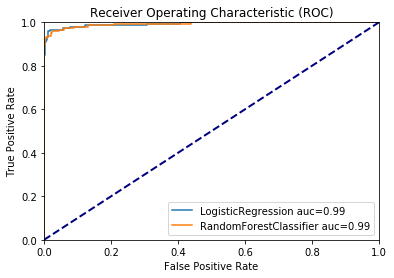

In [22]:
plot_roc(result)

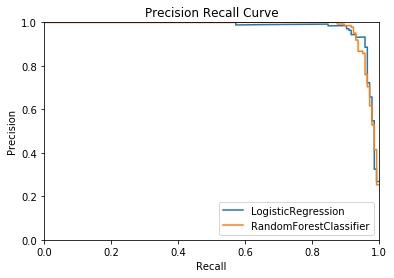

In [23]:
plot_pr(result)

In [24]:
# Understand misclassification
# e.g. Logistic regression, and assume threshold
name = 'LogisticRegression'
threshold = 0.5
understand_misclassification(name, result, data, threshold)


e.g. for LogisticRegression

 Confusion Matrix:
[[965   5]
 [ 12 133]]
             precision    recall  f1-score   support

          0     0.9877    0.9948    0.9913       970
          1     0.9638    0.9172    0.9399       145

avg / total     0.9846    0.9848    0.9846      1115


False positives (ham incorrectly classified as spam):
4633          These won't do. Have to move on to morphine
5157                              K k:) sms chat with me.
2339    Cheers for the message Zogtorius. IåÕve been s...
4727    I (Career Tel) have added u as a contact on IN...
84                                         Yup next stop.
Name: sms, dtype: object

False negatives (spam incorrectly classified as ham):
2429    Guess who am I?This is the first time I create...
5540    ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
4947    Hi this is Amy, we will be sending you a free ...
671            SMS. ac sun0819 posts HELLO:\You seem cool
750     Do you realize that in about 40 years, we'll h..

In [25]:
# Feature importance
feature_importance(vectorizer, models)


Top influencing features sorted by feature importance score:
      LogisticRegression token
7127           14.607385   txt
7155           12.192008    uk
6813           11.832069  text
307            11.153599  150p
6523           10.986825  stop
      RandomForestClassifier token
1630                0.045921  call
6963                0.039931    to
7127                0.030144   txt
3017                0.026241  free
5011                0.023966    or


In [26]:
# Save model to disk
# save_model(models)